# Exp.2 Train KAN

- Dataset: ASCADv1 fixed-key  
    Boolean masking (2-share), software-implementation
- PoI: 10 pts, top-10 indices of scales
- #traces: 50,000 (profiling), 20,000 (attack)
- Preprocess: Z-score normalization
- #attack traces to calculate GE: 2,000
- Labeling: LSB of unmasked SBox output (two class classification)
- Loss function: Softmax cross entropy (torch.nn.BCEWithLogitsLoss)
- Model architecture: [10(Input), 5, 1, 2(Softmax)]  

In [1]:
import torch
from pathlib import Path
import os
import hydra
import numpy as np
import matplotlib.pyplot as plt
import pickle

os.chdir('/workspace')
import src

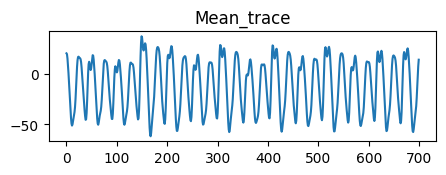

In [2]:
ds = src.datasets.ASCADf.Dataset('/mnt/d/Datasets', scale=False, profiling=True)
target_byte = 2
sim = src.datasets.ASCAD_sim.Dataset(
    ds.plaintext,
    ds.key,
    ds.masks,
    target_byte=target_byte,
    label_transforms=[],
    trace_transforms=[])
keys = ['Unmasked Sbox Output',
        'Masked Sbox Output',
        'Mask of Sbox output',
        'Masked sbox output in linear part',
        'Mask of Sbox output in linear part']
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(len(keys)+1, 1, 1)
x = np.array([ds[v][0] for v in range(len(ds))], dtype=np.float32)
ax.plot(x.mean(axis=0))
ax.set_title('Mean_trace')

snr = {}
for i, k in enumerate(keys):
    t = np.array([sim.calc_ivs(v)[i] for v in range(len(ds))], dtype=np.float32)
    snr[k] = src.sca_utils.snr_fast(x, t)

In [3]:
top = np.array([536, 178, 535, 514, 563, 564, 565, 148, 149, 180, 15, 126, 150, 562, 125, 513, 566, 356, 606, 511, 147, 337, 509, 177, 143, 329, 66, 0, 141, 512, 154, 365, 124, 589, 347, 123, 582, 146, 153, 223, 595, 69, 158, 374, 465, 587, 22, 67, 181, 167, 342, 357, 534, 175, 553, 598, 506, 567, 594, 432, 128, 16, 363, 209, 387, 537, 697, 462, 510, 86, 7, 75, 561, 544, 528, 499, 179, 335, 119, 184, 527, 152, 330, 351, 366, 9, 334, 354, 538, 222, 127, 100, 155, 72, 325, 176, 151, 93, 298, 402, 578, 545, 164, 590, 633, 350, 1, 479, 287, 349, 573, 134, 114, 2, 364, 171, 539, 393, 328, 218, 89, 122, 220, 698, 346, 91, 157, 185, 33, 268, 581, 552, 193, 300, 207, 577, 617, 174, 88, 90, 173, 659, 142, 14, 579, 455, 355, 275, 515, 359, 60, 400, 677, 46, 301, 360, 195, 571, 85, 6, 183, 616, 83, 238, 481, 277, 496, 478, 405, 118, 194, 117, 433, 345, 469, 657, 530, 170, 333, 640, 137, 327, 219, 585, 369, 191, 106, 401, 341, 166, 212, 526, 208, 45, 591, 508, 279, 673, 44, 241, 517, 584, 156, 655, 68, 639, 610, 551, 451, 35, 138, 489, 377, 188, 130, 254, 202, 305, 120, 521, 121, 59, 34, 644, 61, 240, 8, 165, 614, 378, 693, 101, 602, 297, 612, 549, 646, 607, 182, 522, 593, 315, 276, 670, 353, 76, 645, 361, 600, 116, 556, 265, 483, 235, 246, 404, 92, 548, 691, 648, 690, 21, 471, 296, 486, 348, 588, 383, 320, 388, 464, 635, 322, 214, 331, 293, 572, 226, 490, 601, 459, 398, 284, 237, 160, 269, 399, 213, 17, 609, 671, 425, 525, 463, 500, 243, 370, 546, 382, 96,])
pois = top[:10]
poistr = '['
for i in pois:
    poistr += f'[{i},{i+1},1],'
poistr = poistr[:-1]+']'
print(pois)
print(len(pois))

[536 178 535 514 563 564 565 148 149 180]
10


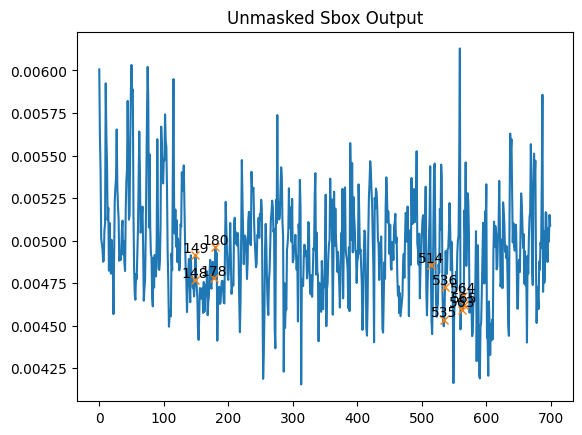

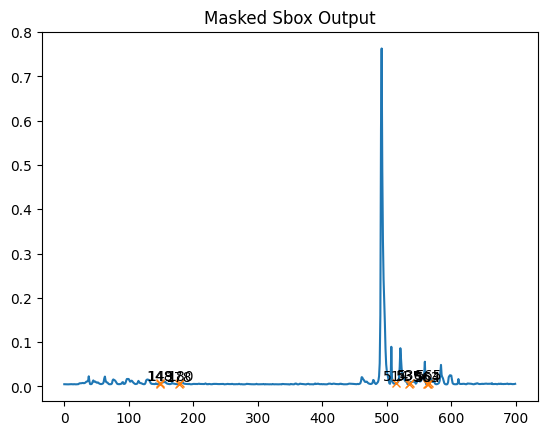

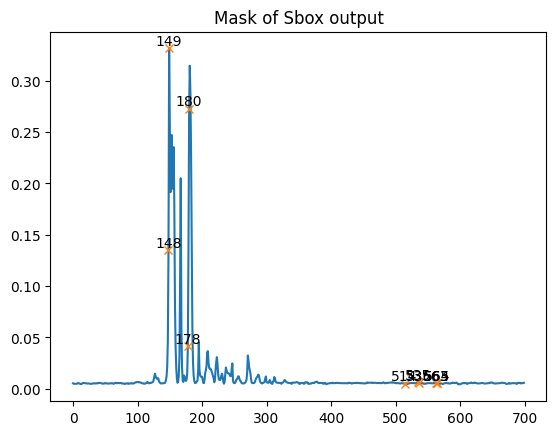

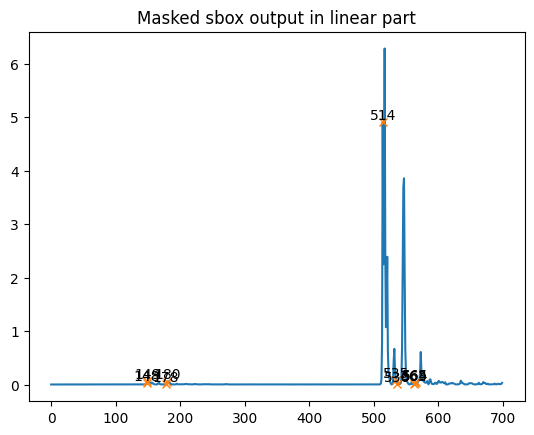

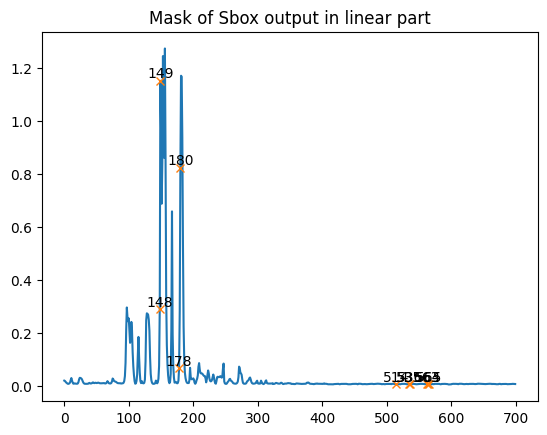

In [4]:
poi=pois
for k in snr.keys():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(k)
    ax.plot(snr[k])
    ax.plot(poi, snr[k][poi], 'x')
    for p in poi:
        ax.text(p, snr[k][p], str(p), ha='center', va='bottom')

In [5]:
with hydra.initialize(config_path="../conf", version_base='1.1'):
    cfg = hydra.compose(
        config_name='config',
        overrides=[
            "model=KAN2h",
            "model.model.width.1=5",
            "model.model.width.2=1",
            "model.train_params.steps=7000",
            "dataset@train=ASCADf_profiling",
            "dataset@test=ASCADf_attack",
            "trace_transforms=set_poi",
            "trace_transforms.transforms.0.pois="+poistr,
            "trace_transforms.output_size="+f'{len(pois)}',
            "label_transforms=bit",
            "label_transforms.transforms.3.pos=0",
            "save_path=/workspace/notebook/results/exp3/",
            "n_attack_traces=2000"
            ]
        )

In [6]:
device = hydra.utils.instantiate(cfg.device)
cpu = torch.device('cpu')

Setup dataset

In [7]:
profiling_dataset = hydra.utils.instantiate(cfg.train.dataset)
test_dataset = hydra.utils.instantiate(cfg.test.dataset)

train_dataloader = torch.utils.data.DataLoader(
    profiling_dataset, batch_size=cfg.train.batch_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=cfg.test.batch_size, shuffle=False
)
KANds = src.utils.to_KAN_dataset(
    train_dataloader, test_dataloader,
    device=device)

Train KAN

In [8]:
model = hydra.utils.instantiate(cfg.model.model)
if not Path(cfg.save_path, cfg.model_name+'.ckpt').exists():
    model = model.to(device)
    _ = model.train(
        KANds,
        **hydra.utils.instantiate(cfg.model.train_params)
        )
    Path(cfg.save_path).mkdir(exist_ok=True, parents=True)
    model.to(cpu).save_ckpt(cfg.model_name+'.ckpt', cfg.save_path)
else:
    model.load_ckpt(cfg.model_name+'.ckpt', cfg.save_path)
model = model.to(device)

train loss: 8.23e-01 | test loss: 8.10e-01 | reg: 2.07e+00 : 100%|█| 7000/7000 [10:58<00:00, 10.63it


save this model to /workspace/notebook/results/exp3//KAN-2Hidden.ckpt


Evaluation

In [9]:
preds, labels, th = src.utils.make_prediction(
    model, test_dataloader, device,
    cfg.label_transforms.one_hot)
preds_class = np.argmax(preds, axis=1)
accuracy = np.mean(labels == preds_class)
print('Accuracy: ', accuracy)

Accuracy:  0.583


Calculate guessing entropy

In [10]:
correct_key = test_dataset.key[0][cfg.target_byte]
key_hyposesis = range(256)
if not Path(cfg.save_path, 'label_hyposesis.npy').exists():
    label_hyposesis = src.utils.make_label_hyposesis(
        test_dataset, key_hyposesis, one_hot=cfg.label_transforms.one_hot)
    np.save(Path(cfg.save_path, 'label_hyposesis.npy'), label_hyposesis)
label_hyposesis = np.load(Path(cfg.save_path, 'label_hyposesis.npy'))
ge = src.sca_utils.calc_guessing_entropy(
    preds, label_hyposesis, correct_key,
    cfg.n_attack_traces, n_trial=cfg.n_trials)

Calculating GE [/trials]: 100%|██████████| 40/40 [00:01<00:00, 35.76it/s]


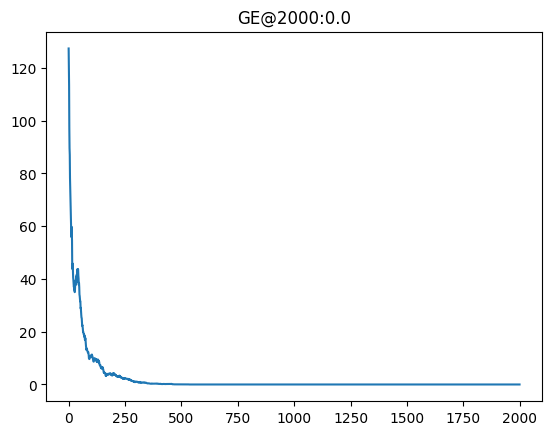

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ge)
ax.set_title(f'GE@{cfg.n_attack_traces}:{ge[-1]}')
fig.savefig(Path(cfg.save_path, f'{cfg.model.name}.png'), dpi=300)